# Task:

Let X - elements of original space of large dimensionality. There is the autoencoder that transforms Х into x - elements of latent space with small dimensionality and vice versa. We have function Ф(X) and the costs of calculating Ф(X) is high. We need to build analogious function ф(х) on latent space, such that if X <-> х, then Ф(Х) = ф(х). Here ф(х) - neural network. As a dataset MNIST is used.

We have 3 questions:

1. Ф(Х) - binary or continious. E.g.: Ф(Х) = I(X - even number), Ф(Х) - mean intensity of pixels.
2. Ф(Х) - parametric function Ф(Х, P).  E.g.:  Ф(Х, Р) - value of pixel with coordinate Р,  Ф(Х, Р) - sum of pixel values for row with number Р, Ф(Х, Р) = corr(X, P)
3. How can we adapt the autoencoder's training procedure in order to increase the quality of calculating ф(х)?


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

import time
from copy import deepcopy

import matplotlib.pyplot as plt
from IPython import display

### Loading data (MNIST)

Here we load MNIST data, do basic transofmations and create DataLoaders to iterate through the data. 

Batch size=128 is quite common and it worked well, so it won't be tuned.

In [4]:
if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')

In [5]:
def to_img(x):
    x = x.view(x.size(0), 1, 28, 28)
    return x


def plot_sample_img(img, name):
    img = img.view(1, 28, 28)
    save_image(img, './sample_{}.png'.format(name))


def min_max_normalization(tensor, min_value, max_value):
    min_tensor = tensor.min()
    tensor = (tensor - min_tensor)
    max_tensor = tensor.max()
    tensor = tensor / max_tensor
    tensor = tensor * (max_value - min_value) + min_value
    return tensor


def tensor_round(tensor):
    return torch.round(tensor)

In [6]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda tensor:min_max_normalization(tensor, 0, 1))
])


In [7]:
train_data = MNIST(root='./data', train=True,
                                   download=True, transform=img_transform)
test_data = MNIST(root='./data', train=False,
                                  download=True, transform=img_transform)

In [8]:
batch_size = 128
dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

__Building and training autoencoder__

* We will train 3 linear autoencoders. All of them consist of 2-layer linear encoder and 2-layer linear decoder.

In [12]:
from utils import Autoencoder, train_autoencoder
from torchsummary import summary

In [13]:
model = Autoencoder(64)

In [14]:
summary(model, input_size=(1, 28 * 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         200,960
              ReLU-2               [-1, 1, 256]               0
            Linear-3                [-1, 1, 64]          16,448
              ReLU-4                [-1, 1, 64]               0
            Linear-5               [-1, 1, 256]          16,640
              ReLU-6               [-1, 1, 256]               0
            Linear-7               [-1, 1, 784]         201,488
           Sigmoid-8               [-1, 1, 784]               0
Total params: 435,536
Trainable params: 435,536
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.66
Estimated Total Size (MB): 1.69
----------------------------------------------------------------


In [11]:
learning_rate = 1e-3
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
num_epochs = 80

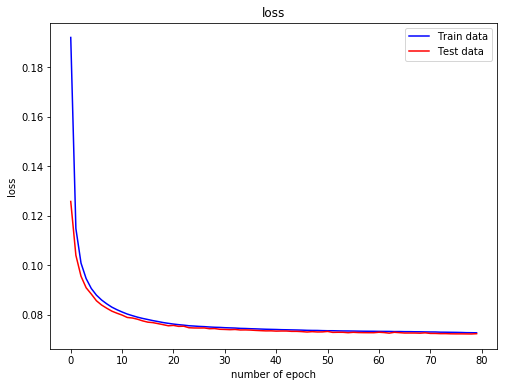

epoch [80/80], train loss:0.0726, train MSE_loss:0.0038, test loss:0.0722, best test loss: 0.0721


In [12]:
train_autoencoder(model, criterion, optimizer, dataloader, test_loader, num_epochs)

In [15]:
model2 = Autoencoder(32)

In [16]:
summary(model2, input_size=(1, 28 * 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         200,960
              ReLU-2               [-1, 1, 256]               0
            Linear-3                [-1, 1, 32]           8,224
              ReLU-4                [-1, 1, 32]               0
            Linear-5               [-1, 1, 256]           8,448
              ReLU-6               [-1, 1, 256]               0
            Linear-7               [-1, 1, 784]         201,488
           Sigmoid-8               [-1, 1, 784]               0
Total params: 419,120
Trainable params: 419,120
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.60
Estimated Total Size (MB): 1.62
----------------------------------------------------------------


In [13]:
learning_rate = 1e-3
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate, weight_decay=1e-5)
num_epochs = 80

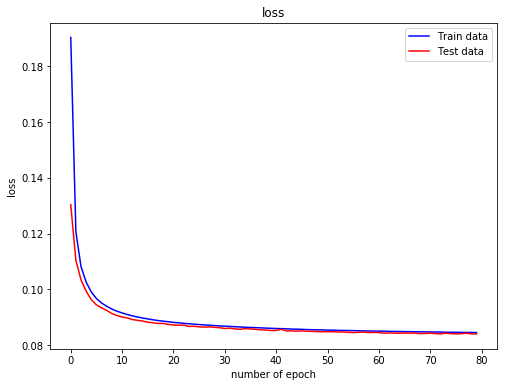

epoch [80/80], train loss:0.0846, train MSE_loss:0.0075, test loss:0.0841, best test loss: 0.0841


In [14]:
train_autoencoder(model2, criterion, optimizer, dataloader, test_loader, num_epochs)

In [17]:
model3 = Autoencoder(128)

In [18]:
summary(model3, input_size=(1, 28 * 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         200,960
              ReLU-2               [-1, 1, 256]               0
            Linear-3               [-1, 1, 128]          32,896
              ReLU-4               [-1, 1, 128]               0
            Linear-5               [-1, 1, 256]          33,024
              ReLU-6               [-1, 1, 256]               0
            Linear-7               [-1, 1, 784]         201,488
           Sigmoid-8               [-1, 1, 784]               0
Total params: 468,368
Trainable params: 468,368
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.79
Estimated Total Size (MB): 1.81
----------------------------------------------------------------


In [15]:
learning_rate = 1e-3
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=learning_rate, weight_decay=1e-5)
num_epochs = 80

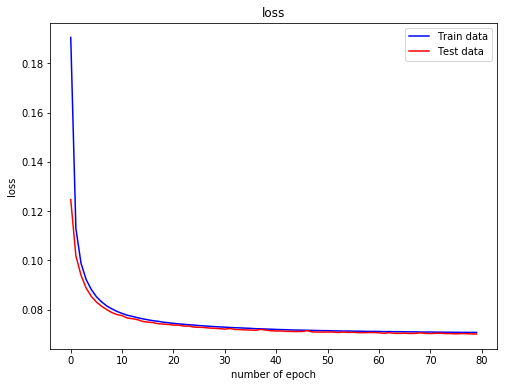

epoch [80/80], train loss:0.0708, train MSE_loss:0.0032, test loss:0.0702, best test loss: 0.0702


In [16]:
train_autoencoder(model3, criterion, optimizer, dataloader, test_loader, num_epochs)

__Example of encoding__

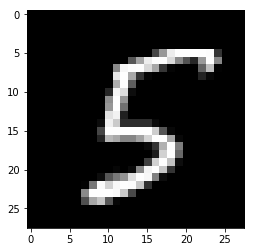

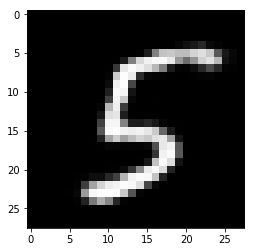

In [20]:
for data in test_loader:
    idx = 23
    img, _ = data
    plt.imshow(img[idx][0], cmap='gray')
    plt.show()
    plt.imshow(model(img.view(img.size(0), -1)[idx]).data.view(28, 28), cmap='gray')
    break

We trained simple linear autoencoder with the hidden sizes 32, 64 and 128. All of them have similar MSE and loss scores.

__Now we explore wether it's possible to calculate functions on latent space.__

## 1. Bollean function:

F(X) = I(X - even number), X -> x, g(x) = I(X - even number)

Binary function - linear neural network with 2 layers. It takes encoded image as an input and predicts wether the original image had odd or even number. 

As it's classification task, cross entropy loss is used for training. 

In [24]:
from utils import Binary_func, train_binary_model

__With latent space size = 64__

In [20]:
boolean_function = Binary_func(64)

In [22]:
summary(boolean_function, input_size=(1, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]          16,640
              ReLU-2               [-1, 1, 256]               0
            Linear-3                 [-1, 1, 2]             514
Total params: 17,154
Trainable params: 17,154
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.07
Estimated Total Size (MB): 0.07
----------------------------------------------------------------


In [83]:
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(boolean_function.parameters(), lr=learning_rate, weight_decay=1e-5)

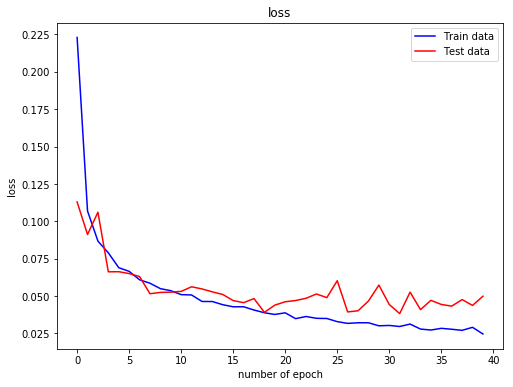

epoch [40/40], train loss:0.0246, train acc:99.1233, test loss:0.0499, test acc:98.4800, best_test_loss :0.0383


In [42]:
train_binary_model(boolean_function, criterion, optimizer, 
                   dataloader, test_loader, model, save_name='boolean_function_64', num_epochs=40)

__With latent space size = 32__

In [25]:
boolean_function2 = Binary_func(32)

In [26]:
summary(boolean_function2, input_size=(1, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]           8,448
              ReLU-2               [-1, 1, 256]               0
            Linear-3                 [-1, 1, 2]             514
Total params: 8,962
Trainable params: 8,962
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [89]:
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(boolean_function2.parameters(), lr=learning_rate, weight_decay=1e-5)

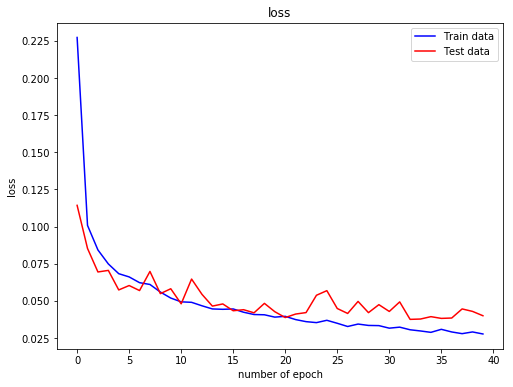

epoch [40/40], train loss:0.0277, train acc:99.0217, test loss:0.0400, test acc:98.6000, best_test_loss :0.0375


In [90]:
train_binary_model(boolean_function2, criterion, optimizer, dataloader, test_loader, 
                   model2, save_name='boolean_function_32', num_epochs=40)

__With latent space size = 128__

In [27]:
boolean_function3 = Binary_func(128)

In [28]:
summary(boolean_function3, input_size=(1, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]          33,024
              ReLU-2               [-1, 1, 256]               0
            Linear-3                 [-1, 1, 2]             514
Total params: 33,538
Trainable params: 33,538
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.13
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


In [92]:
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(boolean_function3.parameters(), lr=learning_rate, weight_decay=1e-5)

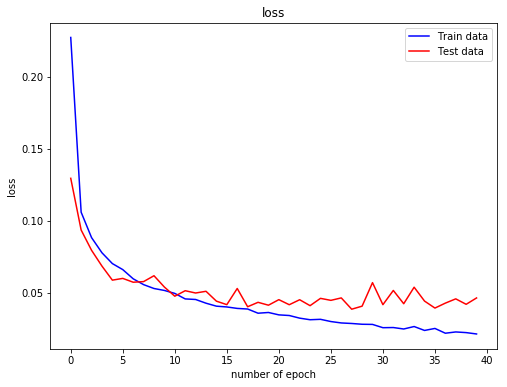

epoch [40/40], train loss:0.0214, train acc:99.2417, test loss:0.0464, test acc:98.4400, best_test_loss :0.0386


In [93]:
train_binary_model(boolean_function3, criterion, optimizer, dataloader, test_loader, 
                   model3, save_name='boolean_function_128', num_epochs=40)

In [116]:
pd.DataFrame({'test cross entropy': [0.0383, 0.0375, 0.0386], 
 'test accuracy': [98.4800, 98.60, 98.44], 'train accuracy': [99.1233, 99.0217, 99.2417]},
            index = ['size: 64', 'size: 32', 'size: 128'])

,test cross entropy,test accuracy,train accuracy
size: 64,0.0383,98.48,99.1233
size: 32,0.0375,98.60,99.0217
size: 128,0.0386,98.44,99.2417


__Conclusions on calculating binary function:__

Almost no change in scores, therefore, for MNIST and this boolean function we can take the smallest size of the latent space because it take less time. 

## 2. Continuous function:

F(X) = mean intensity of X, X -> x, g(x) = mean intensity of X

g(x) - linear neural network, as it's regression task, we use MSE as a loss

In [34]:
from utils import Cont_func, train_cont_model

__Hidden size of the model is 16__

In [30]:
continuous_function = Cont_func(16)

In [31]:
summary(continuous_function, input_size=(1, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 16]           1,040
              ReLU-2                [-1, 1, 16]               0
            Linear-3                 [-1, 1, 1]              17
           Sigmoid-4                 [-1, 1, 1]               0
Total params: 1,057
Trainable params: 1,057
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [53]:
criterion = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(continuous_function.parameters(), lr=learning_rate, weight_decay=1e-5)

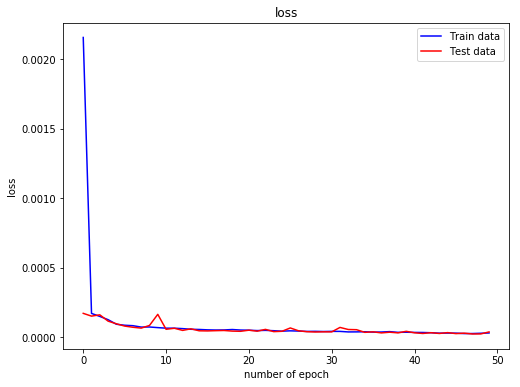

epoch [50/50], train loss:0.000029, test loss:0.000036, best_test_loss:0.000021


In [54]:
train_cont_model(continuous_function, criterion, optimizer, dataloader, test_loader, 
                 model, save_name = 'continuous_function_16', num_epochs=50)

__Hidden size of the model is 8__

In [32]:
continuous_function2 = Cont_func(8)

In [33]:
summary(continuous_function2, input_size=(1, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 8]             520
              ReLU-2                 [-1, 1, 8]               0
            Linear-3                 [-1, 1, 1]               9
           Sigmoid-4                 [-1, 1, 1]               0
Total params: 529
Trainable params: 529
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [95]:
criterion = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(continuous_function2.parameters(), lr=learning_rate, weight_decay=1e-5)

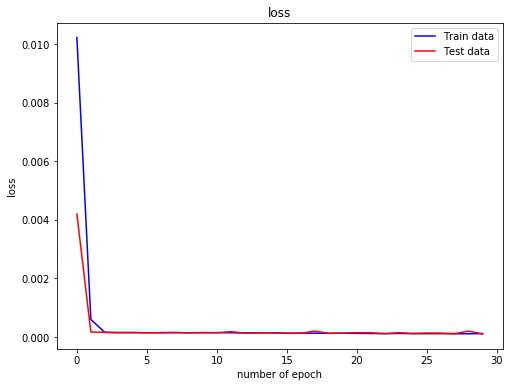

epoch [30/30], train loss:0.000118, test loss:0.000105, best_test_loss:0.000115


In [96]:
train_cont_model(continuous_function2, criterion, optimizer, dataloader, test_loader, 
                 model, save_name = 'continuous_function_8', num_epochs=30)

In [118]:
pd.DataFrame({'best test mse': [0.000115, 0.000021], 
 'train mse': [0.000118, 0.000029]},
            index = ['hiden size: 8', 'hiden size: 16'])

,best test mse,train mse
hiden size: 8,0.000115,0.000118
hiden size: 16,0.000021,0.000029


__Conclusion on continuous function__

Here the scores are better in case of larger hiden space, if we have resources, better to use larger neural network

## 3. Parametric functions

Ф(Х) - функция, зависящая от набора параметров Ф(Х, P). Примеры: Ф(Х, Р) - значение пикселя с координатой Р,  Ф(Х, Р) - сумма по строке с номером Р, Ф(Х, Р) = corr(X, P)

### Ф(Х, Р) - сумма по строке с номером Р

ф(х) - linear neural network that takes as input encoded image and one-hot encoded number of row

In [38]:
from utils import Params_func, train_param_model

__With latent space size = 64__

In [50]:
parametric_function = Params_func(28, latent_dim=64)

In [52]:
criterion = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(parametric_function.parameters(), lr=learning_rate, weight_decay=1e-5)

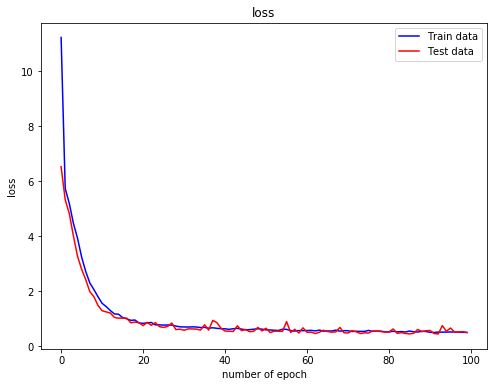

epoch [100/100], train loss:0.5030, test loss:0.4988, best test loss:0.4466


In [79]:
train_param_model(parametric_function, criterion, optimizer, dataloader, test_loader, 
                  model, save_name='parametric_function1_64', num_epochs=100)

__With latent space size = 32__

In [100]:
parametric_function2 = Params_func(28, latent_dim=32)
criterion = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(parametric_function2.parameters(), lr=learning_rate, weight_decay=1e-5)

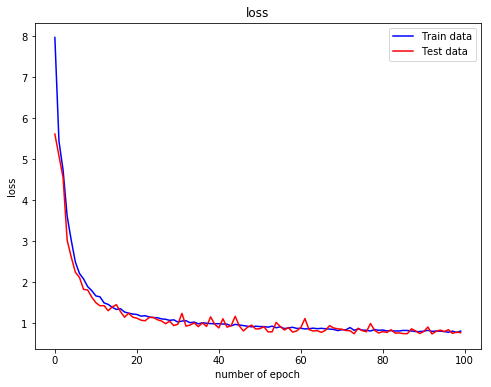

epoch [100/100], train loss:0.8103, test loss:0.7715, best test loss:0.7387


In [101]:
train_param_model(parametric_function2, criterion, optimizer, dataloader, test_loader, 
                  model2, save_name='parametric_function1_32', num_epochs=100)

__With latent space size = 128__

In [102]:
parametric_function3 = Params_func(28, latent_dim=128)
criterion = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(parametric_function3.parameters(), lr=learning_rate, weight_decay=1e-5)

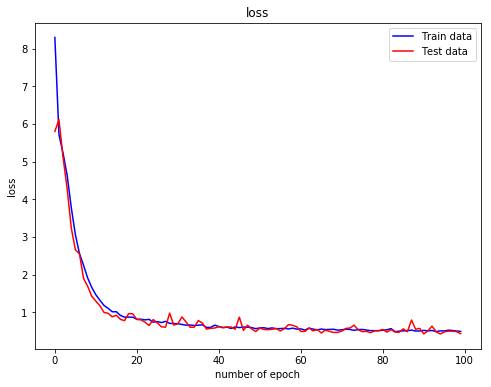

epoch [100/100], train loss:0.4923, test loss:0.4300, best test loss:0.4232


In [103]:
train_param_model(parametric_function3, criterion, optimizer, dataloader, test_loader, 
                  model3, save_name='parametric_function1_128', num_epochs=100)

In [119]:
pd.DataFrame({'best test mse': [0.7387, 0.4466, 0.4232], 
 'train mse': [0.8103, 0.5030, 0.4923]},
            index = ['size: 32', 'size: 64', 'size: 128'])

,best test mse,train mse
size: 32,0.7387,0.8103
size: 64,0.4466,0.5030
size: 128,0.4232,0.4923


__Conclusions on first cont function__

Here we see clear trend when larger network has better quality, depending on our resourced and needed quality we can decide on the architecture.

## P - coordinate

ф(х) - neural network that takes as input encoded image and one-hot encoded coordinate

In [53]:
from utils import Params_func2, train_param_model2

In [105]:
parametric_function2 = Params_func2(28)
criterion = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(parametric_function2.parameters(), lr=learning_rate, weight_decay=1e-5)

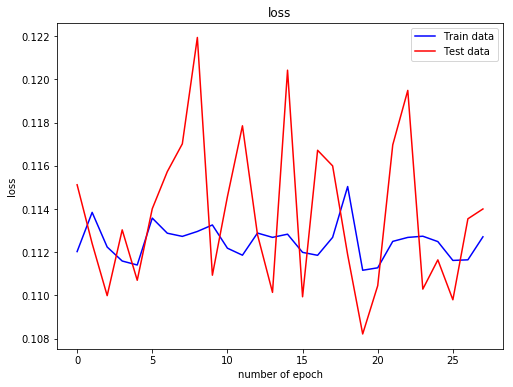

epoch [28/100], train loss:0.1127, test loss:0.1140, best test loss:0.1082


In [106]:
train_param_model2(parametric_function2, criterion, optimizer, dataloader, test_loader, 
                  model3, 'parametric_function2', num_epochs=100)

Trying different architectures and types of encodding the coordinate, it was not possible to train the network. 
One of the probable solutions is to shrink the parameters' space to a smaller one.

## P - arbitrary number image

Ф(Х, Р) = corr(X, P), 

ф(х) - neural network that takes as an input encoded image, and other image. And outputs pearson correlation coefficient

In [63]:
from scipy.stats.stats import pearsonr

In [54]:
from utils import Params_func3, train_param_model3

__With latent space size = 64__

In [65]:
parametric_function3 = Params_func3(28)
criterion = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(parametric_function3.parameters(), lr=learning_rate, weight_decay=1e-5)

In [66]:
other_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
other_test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

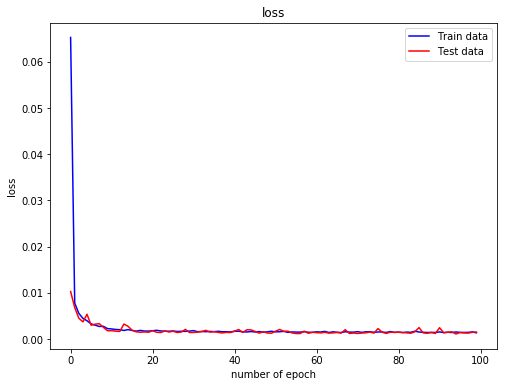

epoch [100/100], train loss:0.0014, test loss:0.0015, best test loss:0.0011


In [67]:
train_param_model3(parametric_function3, criterion, optimizer, dataloader, test_loader,
                   other_dataloader, other_test_loader,
                   model, save_name='parametric_function3_64', num_epochs=100)

__With latent space size = 32__

In [109]:
parametric_function4 = Params_func3(28, 32)
criterion = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(parametric_function4.parameters(), lr=learning_rate, weight_decay=1e-5)

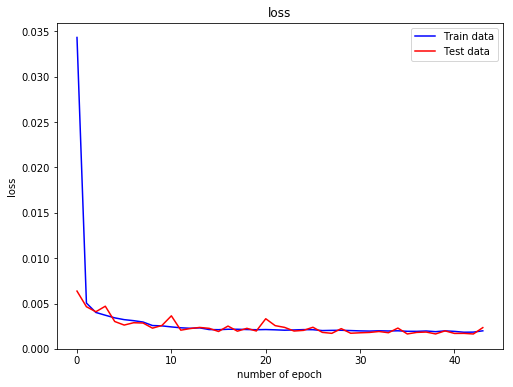

epoch [44/100], train loss:0.0020, test loss:0.0023, best test loss:0.0016


In [111]:
train_param_model3(parametric_function4, criterion, optimizer, dataloader, test_loader,
                   other_dataloader, other_test_loader,
                   model2, save_name='parametric_function3_32', num_epochs=100)

In [120]:
pd.DataFrame({'best test mse': [0.0016, 0.0011], 
 'train mse': [0.0020, 0.0014]},
            index = ['size: 32', 'size: 64'])

,best test mse,train mse
size: 32,0.0016,0.0020
size: 64,0.0011,0.0014


Here encoder with larger latent space gives better quality.

### Conclusions:

The only function that wasn't possible to learn was Ф(Х, Р) - value of pixel with coordinate Р, probably because the parameter space was to large, or it's too hard to extract value of the exact pixel from the latent space.

In other cases the training was sucessfull enough.

### Как можно адаптировать процедуру обучения автоэнкодера, чтобы улучшать точность расчета Ф на скрытом пространстве?


1. One of the ideas is to change the size of the latent space, which was done

2. The other idea is to change the loss function for the autoencoder, e.g. adding some regularization based on the specific task. This was not done yet. Also need to look at more relevant to the history matching task rahther than toy mnist examples. 